# Парсинг данных

**Задача:** Извлечение исторических данных временных рядов по:
- Ключевой ставке;
- Инфляции;
- Индексов RUSFAR;
- Индекса RUONIA.

### Импорт библиотек

In [349]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 50)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook

import requests
import apimoex

### Импорт пользовательской библиотеки

In [2]:
%load_ext autoreload
%autoreload 2

import sys

# setting path
sys.path.append('..')

# importing
from my_lib import *

## Парсинг исторических данных

#### Выгрузим историю наблюдений индекса Мосбиржи (тикер 'IMOEX')

- https://iss.moex.com/iss/engines.xml
- https://iss.moex.com/iss/engines/stock/markets.xml
- https://iss.moex.com/iss/engines/stock/markets/index/boards.xml

### RUSFAR

Напишем функцию извлечения данных

In [353]:
def get_RUSFAR_history(ticker: str, market:str=None,  board:str=None) -> pd.DataFrame:
    
    if (market is None) or (board is None):
        
        market_list = ["index", "shares", "bonds", "ndm", "otc", "ccp", "deposit", "repo", "qnv", 
                       "mamc", "foreignshares", "foreignndm", "moexboard", "gcc", "credit", 
                       "nonresndm","nonresrepo", "nonresccp","standard", "classica" ]

        board_list = ["AGRO", "INAV", "INPF", "MMIX", "RTSI", "SDII", "SNDX"]
        
        break_flag = False
        for market in market_list:
            for board in board_list:

                with requests.Session() as session:
                    data = apimoex.get_board_history(session, ticker, market=market, board=board)
                    data = pd.DataFrame(data)

                    if data.shape[0]!=0:
                        print('Ticker:', ticker)
                        print('Market:', market)
                        print('Board:',  board)
                        break_flag = True
                        break

            if break_flag is True:
                break
    else:
        data = apimoex.get_board_history(session, ticker, market=market, board=board)
        data = pd.DataFrame(data)
    
    
    if data.shape[0] > 0:
        data['SECID'] = [ticker]*data.shape[0]
        
        print(f'Удалось извлечь ts для {ticker}')
    else:
        print(f'Не удалось извлечь ts для {ticker}')

    return data

Взглянем на выгруженные данные:

In [352]:
def ts_first_view(ts: pd.Series):
    
    ticker = ts.name
    print(f'####################################################################')
    print(f'_________________________{ticker}___________________________________')
    print(f'####################################################################')
    display(ts.head(3))
    display(ts.tail(3))
    plot_data(ts, title=f'График тикера {ticker}')
    
    plot_timeStamps(ts)

In [354]:
RUSFAR_index_dict = pd.read_pickle('../data/parsing/raw/RUSFAR_index_dict')

In [355]:
for ticker in RUSFAR_tickers:
    display(RUSFAR_index_dict[ticker].head())

,BOARDID,TRADEDATE,CLOSE,VOLUME,VALUE,SECID
0,MMIX,2018-01-09,7.50,None,NaN,RUSFAR
1,MMIX,2018-01-10,7.11,None,NaN,RUSFAR
2,MMIX,2018-01-11,7.12,None,NaN,RUSFAR
3,MMIX,2018-01-12,7.10,None,NaN,RUSFAR
4,MMIX,2018-01-15,7.19,None,NaN,RUSFAR


,BOARDID,TRADEDATE,CLOSE,VOLUME,VALUE,SECID
0,MMIX,2018-01-09,7.64,None,NaN,RUSFAR1W
1,MMIX,2018-01-10,7.33,None,NaN,RUSFAR1W
2,MMIX,2018-01-11,7.28,None,NaN,RUSFAR1W
3,MMIX,2018-01-12,7.24,None,NaN,RUSFAR1W
4,MMIX,2018-01-15,7.34,None,NaN,RUSFAR1W


,BOARDID,TRADEDATE,CLOSE,VOLUME,VALUE,SECID
0,MMIX,2019-04-22,7.78,None,NaN,RUSFAR2W
1,MMIX,2019-04-23,7.76,None,NaN,RUSFAR2W
2,MMIX,2019-04-24,7.73,None,NaN,RUSFAR2W
3,MMIX,2019-04-29,7.69,None,NaN,RUSFAR2W
4,MMIX,2019-04-30,7.80,None,NaN,RUSFAR2W


,BOARDID,TRADEDATE,CLOSE,VOLUME,VALUE,SECID
0,MMIX,2019-04-18,7.77,None,NaN,RUSFAR1M
1,MMIX,2019-04-19,7.76,None,NaN,RUSFAR1M
2,MMIX,2019-04-22,7.83,None,NaN,RUSFAR1M
3,MMIX,2019-04-23,7.73,None,NaN,RUSFAR1M
4,MMIX,2019-04-24,7.74,None,NaN,RUSFAR1M


,BOARDID,TRADEDATE,CLOSE,VOLUME,VALUE,SECID
0,MMIX,2019-04-18,7.87,None,NaN,RUSFAR3M
1,MMIX,2019-04-19,7.81,None,NaN,RUSFAR3M
2,MMIX,2019-04-22,7.89,None,NaN,RUSFAR3M
3,MMIX,2019-04-23,7.86,None,NaN,RUSFAR3M
4,MMIX,2019-04-24,7.88,None,NaN,RUSFAR3M


- Нас интересует столбец `CLOSE` - дианмика цены соответствующего индекса RUSFAR;
- Столбец `TRADEDATE` необходимо преобразовать к формату DateTime.

Посмотрим на наличие дубликатов

In [356]:
for ticker in RUSFAR_tickers:
    
    print(f'Проверка наличия дубликатов для {ticker}')
    # Сканирование на наличие дубликатов по всем признакам
    columns_to_concider = RUSFAR_index_dict[ticker].columns
    df_duplicated = RUSFAR_index_dict[ticker].duplicated(subset=columns_to_concider)

    n_duplicates = df_duplicated.sum()
    print('Number of duplicates on all columns = ', n_duplicates)
    
    # Сканирование на наличие дубликатов по всем признакам
    columns_to_concider = ['TRADEDATE']
    df_duplicated = RUSFAR_index_dict[ticker].duplicated(subset=columns_to_concider)

    n_duplicates = df_duplicated.sum()
    print('Number of duplicates on TRADEDATE = ', n_duplicates)
    
    print('\n')

Проверка наличия дубликатов для RUSFAR
Number of duplicates on all columns =  0
Number of duplicates on TRADEDATE =  0


Проверка наличия дубликатов для RUSFAR1W
Number of duplicates on all columns =  0
Number of duplicates on TRADEDATE =  0


Проверка наличия дубликатов для RUSFAR2W
Number of duplicates on all columns =  0
Number of duplicates on TRADEDATE =  0


Проверка наличия дубликатов для RUSFAR1M
Number of duplicates on all columns =  0
Number of duplicates on TRADEDATE =  0


Проверка наличия дубликатов для RUSFAR3M
Number of duplicates on all columns =  0
Number of duplicates on TRADEDATE =  0




Посмотрим на признак `TRADEDATE` в части отсутствия ошибок в записях временной шкалы

In [357]:
for ticker in RUSFAR_tickers:
    print(f'\n***{ticker}***')

    ts_local = RUSFAR_index_dict[ticker].copy()

    print('Проверка длин записей:')
    display(ts_local['TRADEDATE'].apply(lambda x: len(str(x))).value_counts())

    print('Разбиение на составляющие')
    ts_local_splited = ts_local['TRADEDATE'].str.split('-', expand=True)
    display(ts_local_splited[0].unique())
    display(ts_local_splited[1].unique())
    display(ts_local_splited[2].unique())


***RUSFAR***
Проверка длин записей:


10    1622
Name: TRADEDATE, dtype: int64

Разбиение на составляющие


array(['2018', '2019', '2020', '2021', '2022', '2023', '2024'],
      dtype=object)

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

array(['09', '10', '11', '12', '15', '16', '17', '18', '19', '22', '23',
       '24', '25', '26', '29', '30', '31', '01', '02', '05', '06', '07',
       '08', '13', '14', '20', '21', '27', '28', '03', '04'], dtype=object)


***RUSFAR1W***
Проверка длин записей:


10    1620
Name: TRADEDATE, dtype: int64

Разбиение на составляющие


array(['2018', '2019', '2020', '2021', '2022', '2023', '2024'],
      dtype=object)

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

array(['09', '10', '11', '12', '15', '16', '17', '18', '19', '22', '23',
       '24', '25', '26', '29', '30', '31', '01', '02', '05', '06', '07',
       '08', '13', '14', '20', '21', '27', '28', '03', '04'], dtype=object)


***RUSFAR2W***
Проверка длин записей:


10    1300
Name: TRADEDATE, dtype: int64

Разбиение на составляющие


array(['2019', '2020', '2021', '2022', '2023', '2024'], dtype=object)

array(['04', '05', '06', '07', '08', '09', '10', '11', '12', '01', '02',
       '03'], dtype=object)

array(['22', '23', '24', '29', '30', '06', '07', '08', '13', '14', '15',
       '16', '17', '20', '21', '27', '28', '31', '03', '04', '05', '10',
       '11', '18', '19', '25', '26', '01', '02', '09', '12'], dtype=object)


***RUSFAR1M***
Проверка длин записей:


10    1299
Name: TRADEDATE, dtype: int64

Разбиение на составляющие


array(['2019', '2020', '2021', '2022', '2023', '2024'], dtype=object)

array(['04', '05', '06', '07', '08', '09', '10', '11', '12', '01', '02',
       '03'], dtype=object)

array(['18', '19', '22', '23', '24', '25', '26', '29', '30', '06', '07',
       '08', '13', '14', '15', '16', '17', '20', '21', '27', '28', '31',
       '03', '04', '05', '10', '11', '01', '02', '09', '12'], dtype=object)


***RUSFAR3M***
Проверка длин записей:


10    1298
Name: TRADEDATE, dtype: int64

Разбиение на составляющие


array(['2019', '2020', '2021', '2022', '2023', '2024'], dtype=object)

array(['04', '05', '06', '07', '08', '09', '10', '11', '12', '01', '02',
       '03'], dtype=object)

array(['18', '19', '22', '23', '24', '25', '26', '29', '30', '06', '07',
       '08', '13', '14', '15', '16', '17', '20', '21', '27', '28', '31',
       '03', '04', '05', '10', '11', '01', '02', '09', '12'], dtype=object)

Преобразуем у нужному виду:

In [358]:
def get_RUSFAR_ts (df_parced: pd.DataFrame) -> pd.Series:
    
    new_df = pd.DataFrame()
    data = df_parced.copy()
    
    ticker = data['SECID'].values[0]
    data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'], 
                                       format='%Y-%m-%d', 
                                       errors='coerce')

    new_df.index = data['TRADEDATE'].values
    new_df[ticker] = data['CLOSE'].values


    return new_df[ticker]

####################################################################
_________________________RUSFAR___________________________________
####################################################################


2018-01-09    7.50
2018-01-10    7.11
2018-01-11    7.12
Name: RUSFAR, dtype: float64

2024-08-15    17.60
2024-08-16    17.54
2024-08-19    17.47
Name: RUSFAR, dtype: float64

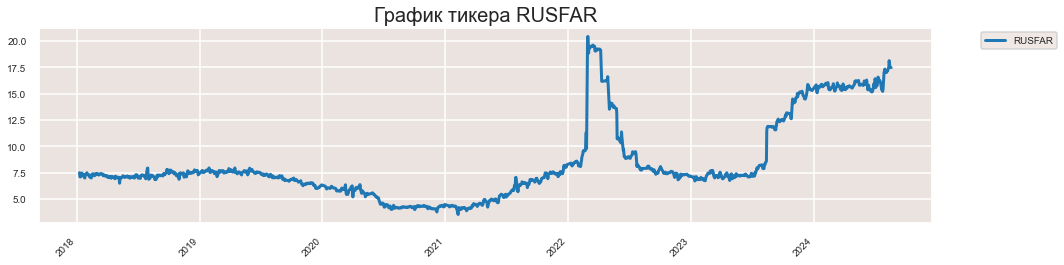

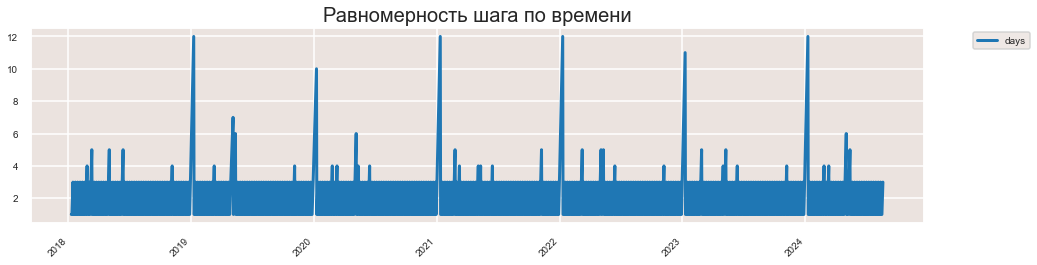

####################################################################
_________________________RUSFAR1W___________________________________
####################################################################


2018-01-09    7.64
2018-01-10    7.33
2018-01-11    7.28
Name: RUSFAR1W, dtype: float64

2024-08-15    17.70
2024-08-16    17.61
2024-08-19    17.63
Name: RUSFAR1W, dtype: float64

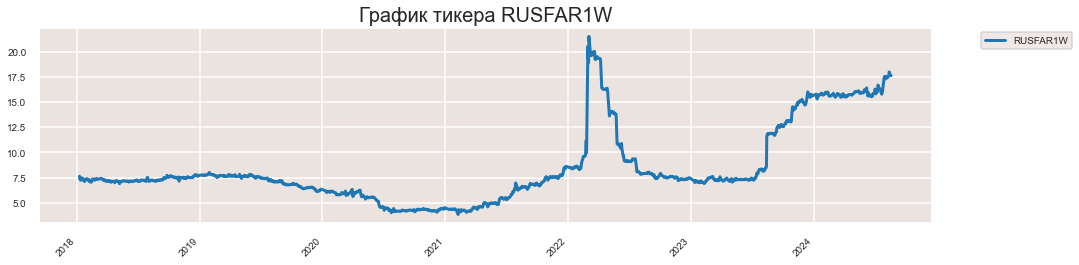

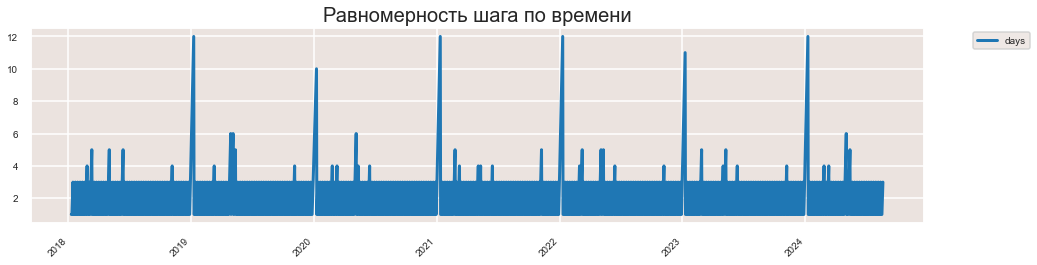

####################################################################
_________________________RUSFAR2W___________________________________
####################################################################


2019-04-22    7.78
2019-04-23    7.76
2019-04-24    7.73
Name: RUSFAR2W, dtype: float64

2024-08-15    17.90
2024-08-16    17.89
2024-08-19    17.79
Name: RUSFAR2W, dtype: float64

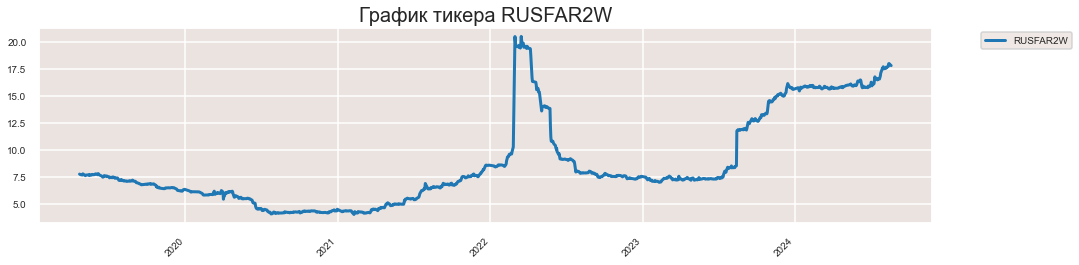

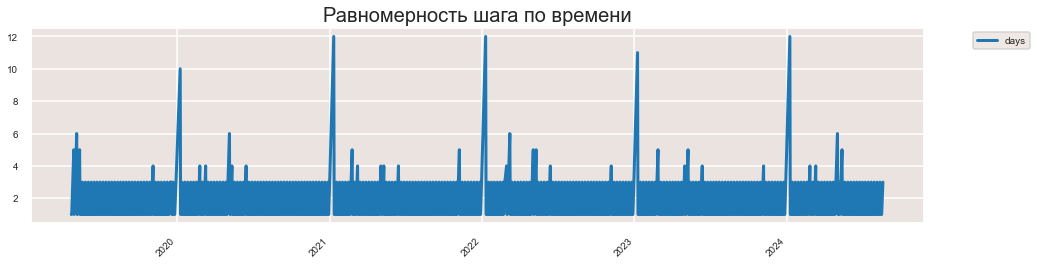

####################################################################
_________________________RUSFAR1M___________________________________
####################################################################


2019-04-18    7.77
2019-04-19    7.76
2019-04-22    7.83
Name: RUSFAR1M, dtype: float64

2024-08-15    17.99
2024-08-16    17.92
2024-08-19    17.91
Name: RUSFAR1M, dtype: float64

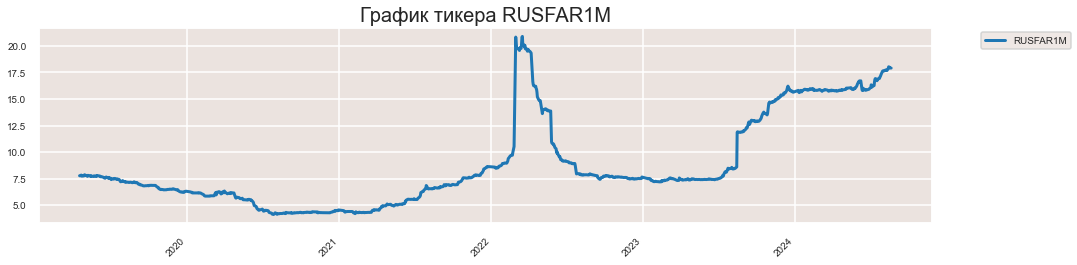

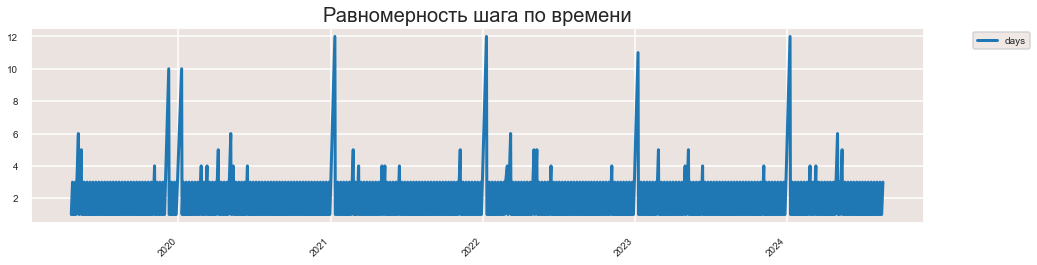

####################################################################
_________________________RUSFAR3M___________________________________
####################################################################


2019-04-18    7.87
2019-04-19    7.81
2019-04-22    7.89
Name: RUSFAR3M, dtype: float64

2024-08-15    18.35
2024-08-16    18.36
2024-08-19    18.38
Name: RUSFAR3M, dtype: float64

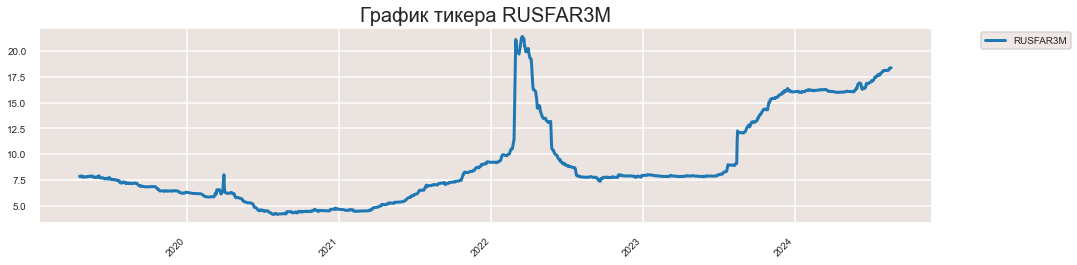

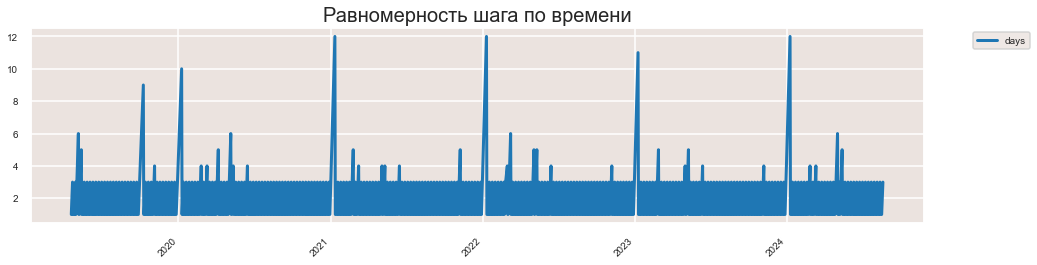

In [359]:
for ticker in RUSFAR_tickers:
    ts = get_RUSFAR_ts(RUSFAR_index_dict[ticker])
    ts_first_view(ts)

Сохраним сформированный временной ряд

In [360]:
ts.to_pickle(f'../data/parsing/cleaned/{ticker}.pkl')

### RUONIA

Загрузим данные выкаченные с сайта

In [361]:
df_RUONIA = pd.read_excel('../data/parsing/raw/RC_F11_01_2010_T15_08_2024.xlsx')
df_RUONIA.head()

,DT,ruo,vol,T,C,MinRate,Percentile25,Percentile75,MaxRate,StatusXML,DateUpdate
0,2024-08-15,17.67,353.32,42.0,19.0,17.5,17.65,17.80,18.15,0.0,2024-08-16 14:14:01.513
1,2024-08-14,17.65,252.40,35.0,16.0,17.5,17.65,17.80,18.00,0.0,2024-08-15 14:10:49.673
2,2024-08-13,18.10,364.41,45.0,22.0,17.8,18.00,18.10,18.30,0.0,2024-08-14 14:08:42.923
3,2024-08-12,17.95,411.03,49.0,21.0,17.2,17.50,18.15,19.00,0.0,2024-08-13 14:08:09.353
4,2024-08-09,17.25,345.16,44.0,19.0,17.1,17.25,17.30,17.60,0.0,2024-08-12 14:08:54.587


- `DT` - Дата ставки;
- `ruo` - Ставка RUONIA, %;
- `vol` - Объем сделок RUONIA, млрд руб.;
- `T` - Количество сделок, ед.;
- `C` - Количество участников RUONIA, совершавших сделки в данный день, ед.;
- `MinRate` - Минимальная процентная ставка, %;
- `Percentile25` - 25-й процентиль по процентным ставкам, %;
- `Percentile75` - 75-й процентиль по процентным ставкам, %;
- `MaxRate` - Максимальная процентная ставка, %;
- `StatusXML` - Статус расчета;
- `DateUpdate` - Дата публикации.

- Нас интересуют столбец `ruo` - динамика индекса RUONIA;
- Необходимо преобразовать столбец `DT` к формату DateTime

Посмотрим на признак `DT` в части отсутствия ошибок в записях временной шкалы

In [362]:
print(f'\n***RUONIA***')

ts_local = df_RUONIA.copy()
ts_local['DT'] = ts_local['DT'].apply(lambda x: str(x))
print('Проверка длин записей:')
display(ts_local['DT'].apply(lambda x: len(x)).value_counts())

print('Разбиение на составляющие')
ts_local_splited = ts_local['DT'].str.split('-', expand=True)
display(ts_local_splited[0].unique())
display(ts_local_splited[1].unique())
display(ts_local_splited[2].unique())


***RUONIA***
Проверка длин записей:


19    3595
Name: DT, dtype: int64

Разбиение на составляющие


array(['2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017',
       '2016', '2015', '2014', '2013', '2012', '2011', '2010'],
      dtype=object)

array(['08', '07', '06', '05', '04', '03', '02', '01', '12', '11', '10',
       '09'], dtype=object)

array(['15 00:00:00', '14 00:00:00', '13 00:00:00', '12 00:00:00',
       '09 00:00:00', '08 00:00:00', '07 00:00:00', '06 00:00:00',
       '05 00:00:00', '02 00:00:00', '01 00:00:00', '31 00:00:00',
       '30 00:00:00', '29 00:00:00', '26 00:00:00', '25 00:00:00',
       '24 00:00:00', '23 00:00:00', '22 00:00:00', '19 00:00:00',
       '18 00:00:00', '17 00:00:00', '16 00:00:00', '11 00:00:00',
       '10 00:00:00', '04 00:00:00', '03 00:00:00', '28 00:00:00',
       '27 00:00:00', '21 00:00:00', '20 00:00:00'], dtype=object)

Напишем функцию формирования требуемого временного ряда для RUONIA

In [363]:
def get_RUONIA_ts (df_parced: pd.DataFrame) -> pd.Series:
    
    new_df = pd.DataFrame()
    data = df_parced.copy()
    
    ticker = 'RUONIA'
    data['DT'] = pd.to_datetime(data['DT'], 
                                       format='%Y-%m-%d', 
                                       errors='coerce')
    
    data.sort_values(by='DT', inplace=True)

    new_df.index = data['DT'].values
    new_df[ticker] = data['ruo'].values


    return new_df[ticker]

Посмотрим на результат

####################################################################
_________________________RUONIA___________________________________
####################################################################


2010-01-11    2.98
2010-01-12    3.10
2010-01-13    3.40
Name: RUONIA, dtype: float64

2024-08-13    18.10
2024-08-14    17.65
2024-08-15    17.67
Name: RUONIA, dtype: float64

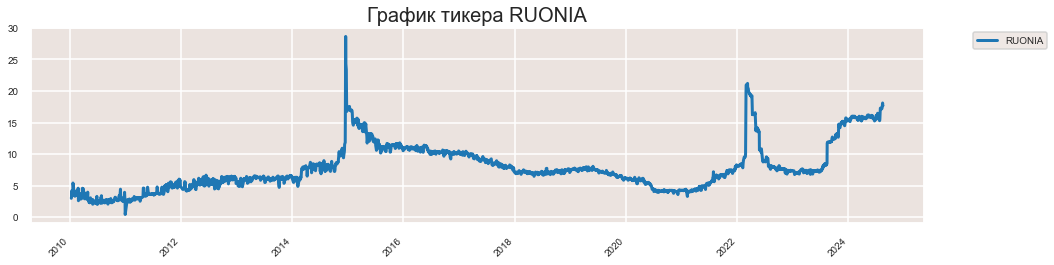

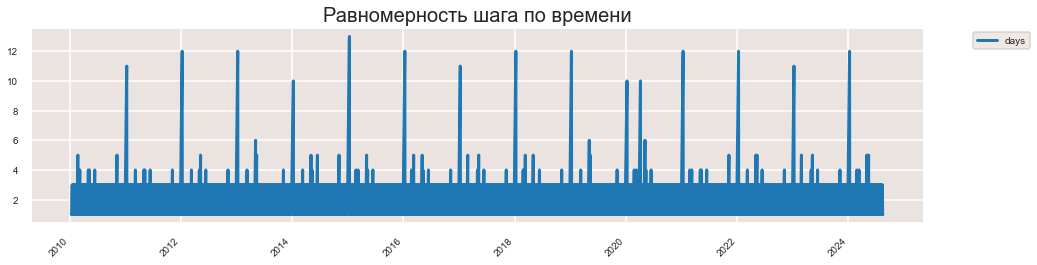

In [364]:
ts = get_RUONIA_ts(df_tikers)
ts_first_view(ts)

Сохраним сформированный временной ряд

In [365]:
ts.to_pickle(f'../data/parsing/cleaned/RUONIA.pkl')

### Ключевая ставка и инфляция

Загрузим данные выкаченные с сайта

In [366]:
df_KEY_INFL = pd.read_excel('../data/parsing/raw/Инфляция и ключевая ставка Банка России_F17_09_2013_T16_08_2024.xlsx')
df_KEY_INFL.head()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции
0,7.2024,18.0,9.13,4.0
1,6.2024,16.0,8.59,4.0
2,5.2024,16.0,8.30,4.0
3,4.2024,16.0,7.84,4.0
4,3.2024,16.0,7.72,4.0


- Нас интересуют столбцы `Ключевая ставка, % годовых` и `Инфляция, % г/г`;
- Столбец `Дата` необходимо преобразовать к формату DateTime.

Посмотрим на признак `Дата` в части отсутствия ошибок в записях временной шкалы

In [367]:
print(f'\n***KEY, INFLATION***')

ts_local = df_KEY_INFL.copy()
ts_local['Дата'] = ts_local['Дата'].apply(lambda x: str(x))
print('Проверка длин записей:')
display(ts_local['Дата'].apply(lambda x: len(x)).value_counts())

print('Разбиение на составляющие')
ts_local_splited = ts_local['Дата'].str.split('.', expand=True)

for col in ts_local_splited.columns:
    display(ts_local_splited[col].unique())


***KEY, INFLATION***
Проверка длин записей:


6    92
7    30
5     9
Name: Дата, dtype: int64

Разбиение на составляющие


array(['7', '6', '5', '4', '3', '2', '1', '12', '11', '10', '9', '8'],
      dtype=object)

array(['2024', '2023', '2022', '2021', '202', '2019', '2018', '2017',
       '2016', '2015', '2014', '2013'], dtype=object)

Видим: 
- наличие отличий длин записей временых отсчетов;
- наличие ошибки - **'202'** в разряде years, который, скорее всего, является значением **'2020'**

Напишем функцию формирования временных рядов динамики Ключевой ставки и Инфляции

In [368]:
def key_date_corr(date_col: pd.Series) -> pd.Series:
    
    temp_df = pd.DataFrame()
    date_col = date_col.apply(lambda x: str(x).split('.'))
    
    temp_df ['month'] = date_col.apply(lambda x: x[0])
    temp_df ['year']  = date_col.apply(lambda x: x[1])
    
    temp_df['year'] = temp_df['year'].apply(lambda x: '2020' if x=='202' else x)
    
    temp_df['date'] = temp_df.apply(lambda x: pd.to_datetime(f'{x.year}-{x.month}'), axis=1)
    
    return temp_df['date']

In [369]:
def get_KEY_and_infl_ts (df_parced: pd.DataFrame) -> pd.Series:
    
    new_df = pd.DataFrame()
    data = df_parced.copy()
    
    data['Дата'] = key_date_corr(data['Дата'])
    
    data.sort_values(by='Дата', inplace=True)

    new_df.index = data['Дата'].values
    new_df['KEY'] = data['Ключевая ставка, % годовых'].values
    new_df['inflation'] = data['Инфляция, % г/г'].values


    return new_df['KEY'], new_df['inflation']

Посмотрим на результаты

####################################################################
_________________________KEY___________________________________
####################################################################


2013-09-01    5.5
2013-10-01    5.5
2013-11-01    5.5
Name: KEY, dtype: float64

2024-05-01    16.0
2024-06-01    16.0
2024-07-01    18.0
Name: KEY, dtype: float64

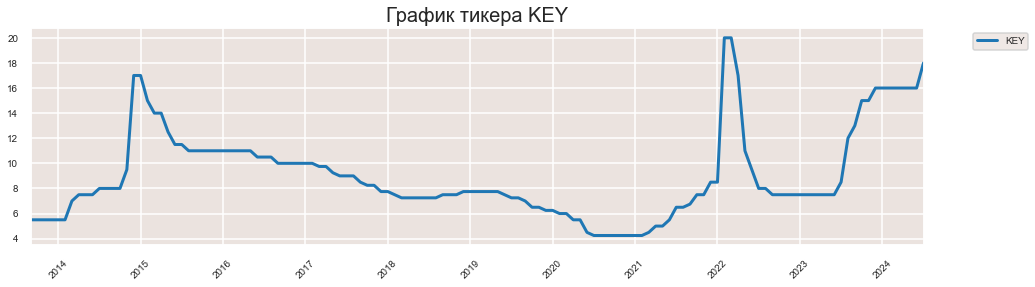

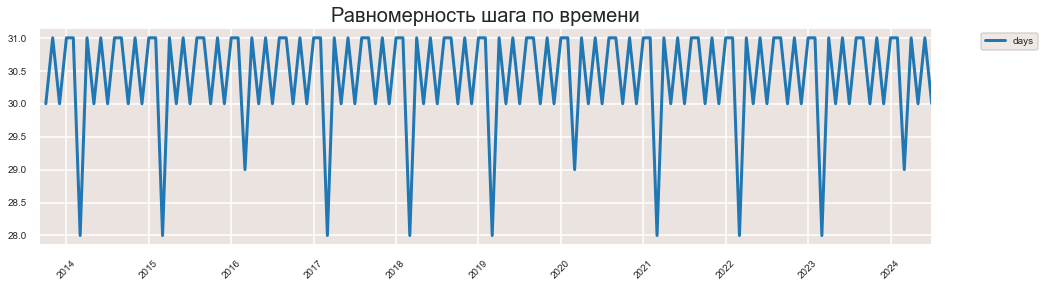

####################################################################
_________________________inflation___________________________________
####################################################################


2013-09-01    6.14
2013-10-01    6.27
2013-11-01    6.50
Name: inflation, dtype: float64

2024-05-01    8.30
2024-06-01    8.59
2024-07-01    9.13
Name: inflation, dtype: float64

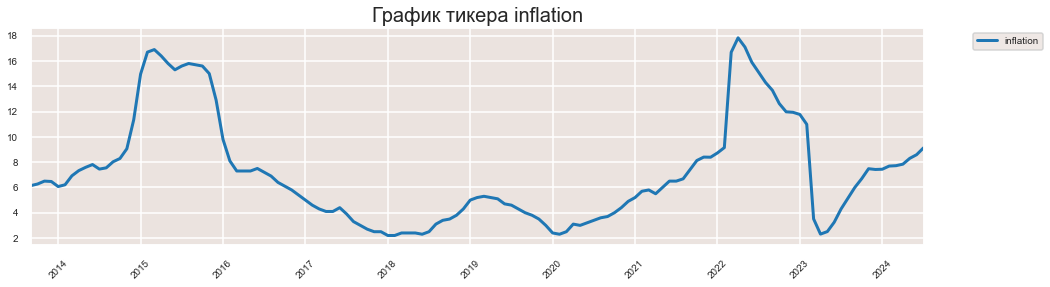

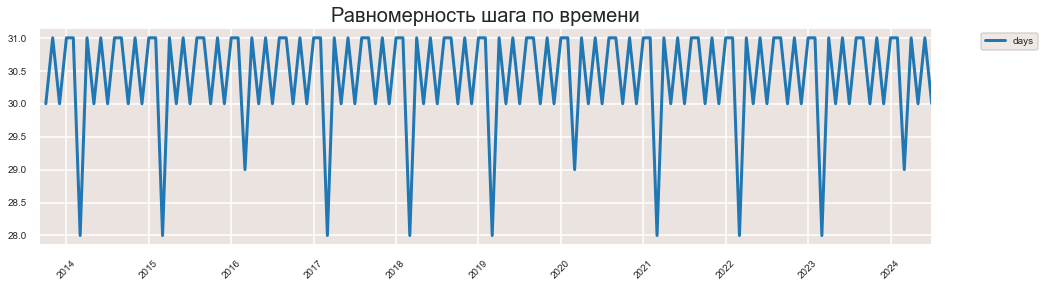

In [370]:
ts_key, ts_infl = get_KEY_and_infl_ts(df_KEY_INFL)
ts_first_view(ts_key)
ts_first_view(ts_infl)

Сохраним сформированные временные ряды

In [371]:
ts_key.to_pickle(f'../data/parsing/cleaned/KEY.pkl')
ts_infl.to_pickle(f'../data/parsing/cleaned/INFLATION.pkl')